# **COMP 2211 Exploring Artificial Intelligence** #
## Programming Assignment 2 - Movie Sentiment Classification ##
![imdb_movie.png](https://static1.srcdn.com/wordpress/wp-content/uploads/2017/09/IMDB.jpg?q=50&fit=crop&w=943&h=&dpr=1.5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
import textwrap
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Sentiment Classification**

Sentiment classification is the task of identifying and categorizing the emotional tone or opinion expressed through textual information. It is commonly used across various applications, ranging from product reviews, social media analysis, and customer feedback.

In this assignment, we will be using deep learning to classify the sentiment of various movies reviews from IMDb. More specifically, we will be building a multilayer perceptron and a convolutional neural network to process and classify reviews into binary sentiments - positive or negative.

## Preparing the Dataset

For this assignment, we will be using *IMDB Movie Ratings Dataset*. The original dataset consists of 40,000 movie reviews labelled as 1 for positive and 0 for negative. Note that the TAs have provided a smaller sample of this dataset to create hidden tests cases which be utilized later for grading.

You can visualize the dataset by running the 2 cells below. Before running them, you will need to upload the movie.csv file to Google Colab by navigating to *Files* on the left. **Please be aware that the files you upload to Colab will not be available forever. Once your runtime disconnects, you will need to reupload the files to continue working.**




In [ ]:
if __name__ == '__main__':
  movies_data = pd.read_csv('movies_data.csv')
  movies_data.head()

In [ ]:
if __name__ == '__main__':
  movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    32000 non-null  object
 1   label   32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


# Data Preprocessing (2 Tasks)

Before training a deep learning model for sentiment classification, it is important to preprocess the textual data to improve model performance and efficiency. This typically involves steps such as lowercasing, removing punctuation and stopwords, tokenization, and converting text to numerical format using word embeddings. Proper processing helps the model focus on meaningful patterns while reducing noise and spatial dimensions.

In this section, we will use the `re` library to work with **regular expressions**. This library will be used to preprocess and manipulate the text reviews by converting them to lowercase, remove punctuation, handle negations, and clean any HTML/web tags, helping prepare the text for deep learning models.


Understand that the preprocessing steps will change depending on the architecture to train. In this section, we will be carrying out all the preprocessing steps which are common across both MLP and CNN models. We will further preprocess text for each model in the subsequent steps. For now, complete the tasks below to continue with the assignment.

***New Terminologies:***

1. Tokenization: breaking down text into smaller units called tokens, typically words or subwords.
2. Lemmatization: reduces words to their base or dictionary form (lemma). For example, "running" becomes "run", improving model generalization.
3. Word Embeddings: numerical vector representations of words that capture their semantic meaning.

***Documentation:***
You can use the documentation links below to solve Tasks 1 and 2.
1. pandas: https://pandas.pydata.org/docs/reference/index.html
2. re: https://docs.python.org/3/library/re.html


Write code in the cell below to complete tasks 1 and 2.

**Task 1** — Complete the `remove_duplicates()` function.

**Task 2** — Complete the `clean_text(`) function.

In [ ]:
def remove_duplicates(df):
  # Task 1: Check whether there are duplicates and remove them.
  ###### TO DO ######

  if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)

  ###################

  return df

def clean_text(text):
  # Task 2: Follow the steps below to complete the function.
  ###### TO DO ######

  text = text.lower()  # Convert to lowercase
  text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
  text = re.sub(r'\bnot\s+(\w+)', r'not_\1', text)  # Handle negations, i.e., "not happy" => "not_happy"
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = re.sub(r'\d+', '', text)  # Remove digits
  text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

  ###################

  return text

if __name__ == '__main__':
  movies_data = remove_duplicates(movies_data)
  movies_data['cleaned_text'] = movies_data.text.apply(clean_text)

  # Read the first review before after text cleaning to spot any differences.
  print(textwrap.fill(movies_data['text'][0], width=100), end='\n\n')
  print(textwrap.fill(movies_data['cleaned_text'][0], width=100))

A novel by Remarque. A cast that looks great on paper. A left-wing refugee struggling to remain in
Paris between the wars. A Gestapo officer undercover.<br /><br />It's a pity there's no synergy
here. The bits and pieces never coalesce.<br /><br />Stories about left-wing refugees in France
don't have to be this dull. Read Arthur Koestler's memoir "Scum of the Earth" (if you can find it).
Or his chilling "Dialogue With Death" (ditto).<br /><br />To me, the only interest in this film lies
in some of the incidental details.<br /><br />The leads spend a lot of time drinking calvados, the
Norman apple brandy. I welcome any prompting to have a nip of calvados myself. It certainly made
this film appear to pass more quickly. But, according to the film, it's only sold in cheap, low-
class saloons. Vive le tabac parisien! That's what I say. References to intoxicating liquors do
abound here; that would seem to be a preoccupation of the scenarists.<br /><br />I enjoy films set
in France because it

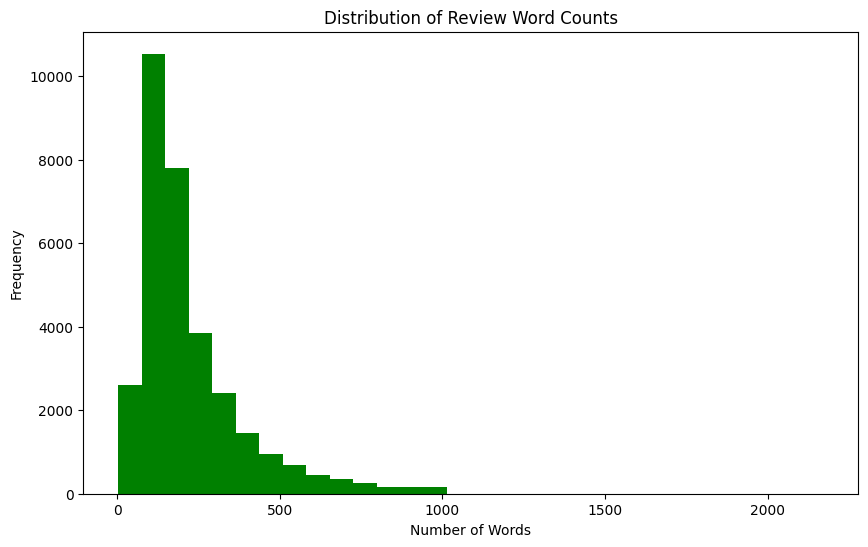

In [ ]:
if __name__ == '__main__':
  movies_data['word_count'] = movies_data['cleaned_text'].apply(lambda x: len(x.split()))
  plt.figure(figsize=(10, 6))
  plt.hist(movies_data['word_count'], bins=30, color='green')
  plt.title("Distribution of Review Word Counts")
  plt.xlabel("Number of Words")
  plt.ylabel("Frequency")
  plt.show()

# Multilayer Perceptron (5 Tasks)

In this section, we will build a Multilayer Perceptron (MLP) model to classify movies reviews. Before training the model, we will perform some additional, but essential, preprocessing steps including lemmatization and TF-IDF vectorization. These steps will help convert our cleaned text into a numerical format suitable for input into the MLP architecture.

**TF-IDF** **(Term Frequency - Inverse Document Frequency)** is a statistical technique used to represent text data numerically. It assigns weights to words based on how frequently they appear in a document (term frequency) and how rare they are across all documents (inverse document frequency). This assists with highlighting words which are more meaningful in distinguishing between classes, while down-weighting common words.

In this section, we will use the **Natural Language Toolkit (NLTK)** - a powerful Python library for working with human language data. NLTK provides tools for tokenization, stopword removal, and lemmatization, which are essential for cleaning and preparing text.

Write code in the cells below to complete the following tasks:

**Task 3** — complete the `text_preprocessing_mlp() `function.

**Task 4** — complete the `tfidf_vectorization() `function.

**Task 5** — complete the `split_dataset()` function.

***Documentation:***
You can use the documentation link below to work on tasks 3-5.
1. ntlk: https://www.nltk.org/
2. sklearn: https://scikit-learn.org/stable/api/index.html

**Hint:** You may want to take a look at the imported libraries at the start of the notebook, along with the documentation, while working on the code cells below.

In [2]:
# Download the necessary resources from NLTK
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def text_preprocessing_mlp(text):
    # Task 3: Follow the steps below to complete the function.
    ###### TO DO ######

    # Create the WordNetLemmatizer() object
    lemmatizer = WordNetLemmatizer()

    # Split text into tokens
    tokens = text.split()

    # Remove stopwords and short words (2 letters or less)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    ###################

    return ' '.join(tokens)

if __name__ == '__main__':
  movies_data['preprocessed_text_mlp'] = movies_data.cleaned_text.apply(text_preprocessing_mlp)

  print(textwrap.fill(movies_data['cleaned_text'][0], width=100), end='\n\n')
  print(textwrap.fill(movies_data['preprocessed_text_mlp'][0], width=100))

a novel by remarque a cast that looks great on paper a leftwing refugee struggling to remain in
paris between the wars a gestapo officer undercoverits a pity theres no synergy here the bits and
pieces never coalescestories about leftwing refugees in france dont have to be this dull read arthur
koestlers memoir scum of the earth if you can find it or his chilling dialogue with death dittoto me
the only interest in this film lies in some of the incidental detailsthe leads spend a lot of time
drinking calvados the norman apple brandy i welcome any prompting to have a nip of calvados myself
it certainly made this film appear to pass more quickly but according to the film its only sold in
cheap lowclass saloons vive le tabac parisien thats what i say references to intoxicating liquors do
abound here that would seem to be a preoccupation of the scenaristsi enjoy films set in france
because it can be amusing waiting for the inevitable fullsize alcohol ad to pop up on a wall in the
background 

In [ ]:
def tfidf_vectorization(df_col, max_features):
  # Task 4: Follow the steps below to complete the function.
  ###### TO DO ######

  # create tfidfvectorizer object
  vectorizer = TfidfVectorizer(max_features=max_features)

  # apply the object to the dataframe and return an array
  X = vectorizer.fit_transform(df_col).toarray()

  return X

  ###################

if __name__ == '__main__':
  X = tfidf_vectorization(movies_data['preprocessed_text_mlp'], 5000)
  print(X.shape)

(31834, 5000)


In [ ]:
def split_dataset(X, df, test_split_ratio=0.2, rand_state=42):
  # Task 5: Split the dataset into training and testing datasets.
  ###### TO DO ######
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                    df.label,
                                                    test_size=test_split_ratio,
                                                    random_state=rand_state,
                                                    shuffle=True,
                                                    stratify=df.label)

  ###################

  return X_train, X_test, y_train, y_test

if __name__ == '__main__':
  X_train, X_test, y_train, y_test = split_dataset(X, movies_data)

  print("shape of X_train :", X_train.shape)
  print("shape of X_test  :", X_test.shape)
  print("shape of y_train :", y_train.shape)
  print("shape of y_test  :", y_test.shape)

shape of X_train : (25467, 5000)
shape of X_test  : (6367, 5000)
shape of y_train : (25467,)
shape of y_test  : (6367,)


Now it is finally time to build and train your MLP architecture. You have the option to explore different configurations of the MLP model and evaluate its performance. However, you can only use the following 3 layers:
1. `Input()`: defines the shape of the input data that the model will accept. **This should be the first layer of your model.** You will need to make sure the dimensions of your input data are also correct. Link: https://www.tensorflow.org/api_docs/python/tf/keras/Input
2. `Dense()`: you are free to explore the number of filters, activation functions, etc.
3. `Dropout()`: you are free to choose your parameter to prevent overfitting.

A reminder: your last layer should be a dense layer with one neuron, representing the probability of the positive class.

After building your desired architecture, you need to compile the model with following parameters:
1. `optimizer`: an algorithm which updates the model's weight during training to minimize the loss function. You are free to explore different optimizers but we recommend `adam`.
2. `loss`: a mathematical function which measures how far the model's predictions are from actual labels. You are free to choose your own, but we recommend `binary_crossentropy`.
3. metrics: evaluation measures used to assess the model performance. You are free to choose your own, but we recommend either `f1_score` or `accuracy`.

**Task 6** — complete the `get_mlp_model()` function.

**Hint:** The model in our solution uses approximately 160,000 trainable parameters. We suggest you keep the number of trainable parameters under 1,000,000 for efficient training and to avoid overfitting.


In [ ]:
def get_mlp_model():
  # Task 6: Compile and build your MLP model. Return the compiled Keras model.
  ###### TO DO ######
  mlp_model = Sequential([
      Input(shape=(5000,)),
      Dense(32, activation='relu'),
      Dropout(0.5),
      Dense(16, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')])

  mlp_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
  ###################
  return mlp_model

if __name__ == '__main__':
  mlp_model = get_mlp_model()
  mlp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │       160,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,577 (627.25 KB)

 Trainable params: 160,577 (627.25 KB)

 Non-trainable params: 0 (0.00 B)

It is now time to train the model you built in the previous tasks. You are free to explore different configuration of parameters. However, keep in mind that long training times would require more computational resources and time. Additionally, longer training times does not necessarily indicate better model performance due to potential overfitting.

**Task 7** — Train and test your model

In [ ]:
# Task 7: Train and test your model. Feel free to change the codes below
###### TO DO ######
if __name__ == '__main__':
  history = mlp_model.fit(X_train,
                          y_train,
                          epochs=5,
                          batch_size=32,
                          validation_split=0.2)
  loss, accuracy = mlp_model.evaluate(x=X_test, y=y_test, batch_size=8)
  print(f"loss: {loss:.3f}")
  print(f"accuracy: {accuracy:.3f}")
###################

Epoch 1/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6746 - loss: 0.5977 - val_accuracy: 0.8753 - val_loss: 0.3100
Epoch 2/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8941 - loss: 0.2980 - val_accuracy: 0.8781 - val_loss: 0.2951
Epoch 3/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9178 - loss: 0.2481 - val_accuracy: 0.8698 - val_loss: 0.3054
Epoch 4/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9368 - loss: 0.2001 - val_accuracy: 0.8710 - val_loss: 0.3162
Epoch 5/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9455 - loss: 0.1767 - val_accuracy: 0.8653 - val_loss: 0.3542
796/796 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8741 - loss: 0.3405
loss: 0.347
accuracy: 0.875


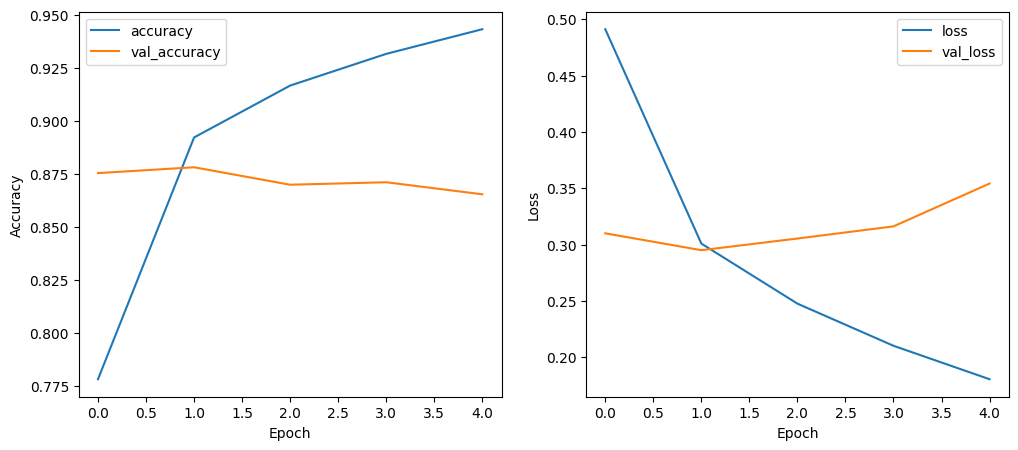

In [ ]:
# Plotting your MLP model's training history.
if __name__ == '__main__':
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

Now that you have finished training your model, you can use the cell below to evaluate your model on the testing dataset. The code will generate predictions (a probability value between 0 and 1) and round it to the nearest integer (the label itself). Finally, the confusion matrix will determine how many labels were predicted correctly and incorrectly.

Feel free to use the cell below to retrain and improve your model if necessary. If you are happy with your trained MLP model, you can save your model and continue to the next section on convolutional neural networks.

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8742 - loss: 0.3407
MLP Accuracy: 0.8748233318328857
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


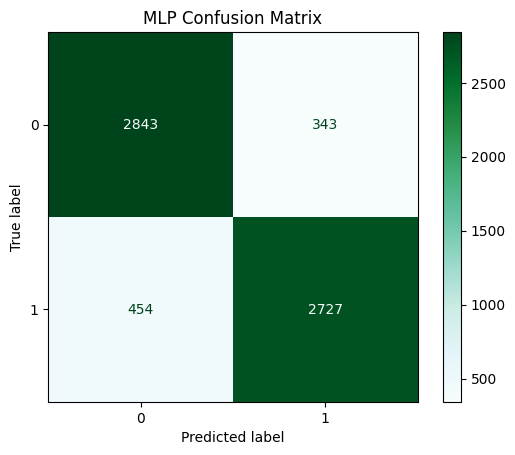

In [ ]:
if __name__ == '__main__':
  # Model Evaluation and Confusion Matrix
  loss, accuracy = mlp_model.evaluate(X_test, y_test)
  print(f"MLP Accuracy: {accuracy}")

  predictions = mlp_model.predict(X_test)
  pred_labels = (predictions > 0.5).astype(int)

  cm = confusion_matrix(y_test, pred_labels)

  ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap='BuGn')
  plt.title("MLP Confusion Matrix")
  plt.show()

You can now run the cell below to save your MLP model. You will need to download this saved model to your local machine for submission.

In [ ]:
if __name__ == '__main__':
  mlp_model.save("mlp_model.keras")

# Convolutional Neural Network (3 Tasks)

In this section, we will build a Convolutional Neural Network (CNN) to classify movie reviews as either positive or negative. CNNs are traditionally used in computer vision, but they can also be highly effective for text classification due to their ability to capture local patterns and relationships between words.

Before we train our CNN model, we need to carry some preprocessing on the cleaned text we generated in tasks 1 and 2. More specifically, we will be performing **tokenization** to convert words into sequences of integers, and apply **padding** to ensure uniform input length across all samples.

In the following 2 cells, we will follow the preprocessing steps tailored specifically for CNNs. Complete the tasks below to prepare your data.

**Task 8** — complete the `tokenize_text()` function below.

***Vectorization Vs. Tokenization:***
1. Vectorization is used to convert text into fixed-length numerical vectors based on frequency and importance. Their outputs are usually dense or a sparse vector.
2. Unlike vectorization, tokenization also preserves word order and is used for sequence-based models, including CNNs, RNNs, LSTMs, etc.
3. With tokenization, models can process sequential data and can learn word relationships through embeddings.

***Documentation:***
You can use the documentation link below to work on task 8. Do not forget to see the imported libraries for hints.
1. tensorflow preprocessing: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing



In [ ]:
def tokenize_text(df, num_words=600, max_len=200):
  # Task 8: Tokenize the data and return the tokenized vectors.
  ###### TO DO ######
  # Create Tokenizer() object where num_words is from the input parameter and oov_token is oov_token.
  # oov_token is used to represent words not in the vocabulty (Out Of Vocabulary)
  tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")

  # Fit the tokenizer on the cleaned text.
  tokenizer.fit_on_texts(df)

  # Convert text into sequences.
  sequences = tokenizer.texts_to_sequences(df)

  # Pad the sequences using post padding and truncate from the end.
  padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

  return padded_sequences

if __name__ == '__main__':
  padded_sequences = tokenize_text(movies_data['cleaned_text'])
  print(padded_sequences)

[[  3   1  32 ...  45  60  72]
 [  1   4   1 ...   0   0   0]
 [ 10 281  11 ...   0   0   0]
 ...
 [ 68  10  26 ...   1   1   1]
 [ 11  19   7 ...   1   1 111]
 [ 11   7   3 ...   0   0   0]]


In [ ]:
if __name__ == '__main__':
  # We used the function you completed in Task 5 to split the dataset.
  X_train, X_test, y_train, y_test = split_dataset(padded_sequences, movies_data)


  print("shape of X_train :", X_train.shape)
  print("shape of X_test  :", X_test.shape)
  print("shape of y_train :", y_train.shape)
  print("shape of y_test  :", y_test.shape)

shape of X_train : (25467, 200)
shape of X_test  : (6367, 200)
shape of y_train : (25467,)
shape of y_test  : (6367,)


Now it is finally time to build and train your CNN architecture. You have the option to explore different configurations of the CNN model and evaluate its performance. However, you can only use the following 6 layers:
1. `Input()`: defines the shape of the input data that the model will accept. **This should be the first layer of your model.** You will need to make sure the dimensions of your input data are also correct. Link: https://www.tensorflow.org/api_docs/python/tf/keras/Input
2. `Embedding()`: Converts words into dense vector representations (embeddings). **This should be the second layer of your model.** You will need to make sure the dimensions of your input data are also correct. Link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
3. `Dense()`: you are free to explore the number of filters, activation functions, etc.
4. `Dropout()`: you are free to choose your parameter to prevent overfitting.
5. `Conv1D`: Applies 1D convolution filters across the sequence to detect word combinations or phrases. You are free to choose the number of kernels, kernel size, activation functions, etc. You should use AT LEAST one in your model. Link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
6. `GlobalMaxPooling1D`: Reduces the output of the convolutional layer by selecting the maximum value from each feature map. We recommend you keep the default values of its parameters. You should use AT LEAST one in your model. Link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D

A reminder: your last layer should be a dense layer with one neuron, representing the probability of the positive class.

After building your desired architecture, you need to compile the model with following parameters:
1. `optimizer`: an algorithm which updates the model's weight during training to minimize the loss function. You are free to explore different optimizers but we recommend `adam`.
2. `loss`: a mathematical function which measures how far the model's predictions are from actual labels. You are free to choose your own, but we recommend `binary_crossentropy`.
3. metrics: evaluation measures used to assess the model performance. You are free to choose your own, but we recommend either `f1_score` or `accuracy`.

**Task 9** — complete the `get_cnn_model()` function.

**Hint:** The model in our solution uses approximately 110,000 trainable parameters. We suggest you keep the number of trainable parameters under 1,000,000 for efficient training and to avoid overfitting.


In [ ]:
def get_cnn_model(max_len):
   # Task 9: Compile and build your CNN model. Return the compiled Keras model.
  ###### TO DO ######
  cnn_model = Sequential([
      Input(shape=(max_len,)),
      Embedding(input_dim=600, output_dim=100),
      Conv1D(filters=100, kernel_size=5, activation='relu'),
      GlobalMaxPooling1D(),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid')
  ])

  cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  ##################
  return cnn_model

if __name__ == '__main__':
  max_len = 200
  cnn_model = get_cnn_model(max_len)
  cnn_model.build(input_shape=(None, max_len))
  cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │        60,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 196, 100)       │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,121 (434.07 KB)

 Trainable params: 111,121 (434.07 KB)

 Non-trainable params: 0 (0.00 B)

It is now time to train the CNN model you built in the previous tasks. You are free to explore different configuration of parameters. However, keep in mind that long training times would require more computational resources and time. Additionally, longer training times does not necessarily indicate better model performance due to potential overfitting.

Note: CNNs on average take longer to train than MLPs so be sure to adjust parameters accordingly.

**Task 10** — Train and test your model

In [ ]:
# Task 10: Train and test your CNN model. Feel free to change the codes below
###### TO DO ######
if __name__ == '__main__':
  history = cnn_model.fit(X_train,
                          y_train,
                          epochs=5,
                          batch_size=32,
                          validation_split=0.2)
  loss, accuracy = cnn_model.evaluate(x=X_test, y=y_test, batch_size=8)
  print(f"loss: {loss:.3f}")
  print(f"accuracy: {accuracy:.3f}")
###################

Epoch 1/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.6761 - loss: 0.5751 - val_accuracy: 0.8033 - val_loss: 0.4236
Epoch 2/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8409 - loss: 0.3588 - val_accuracy: 0.8155 - val_loss: 0.4043
Epoch 3/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8793 - loss: 0.2892 - val_accuracy: 0.8166 - val_loss: 0.4072
Epoch 4/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9116 - loss: 0.2194 - val_accuracy: 0.8163 - val_loss: 0.4395
Epoch 5/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9498 - loss: 0.1520 - val_accuracy: 0.8161 - val_loss: 0.4947
796/796 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8278 - loss: 0.4601
loss: 0.459
accuracy: 0.828


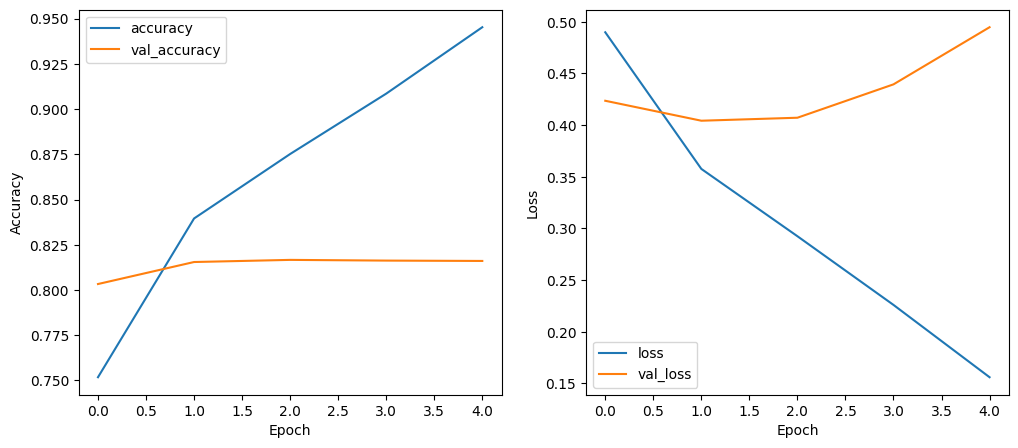

In [ ]:
if __name__ == '__main__':
  # Plotting your CNN model's training history.
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8281 - loss: 0.4592
CNN Accuracy: 0.8281765580177307
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


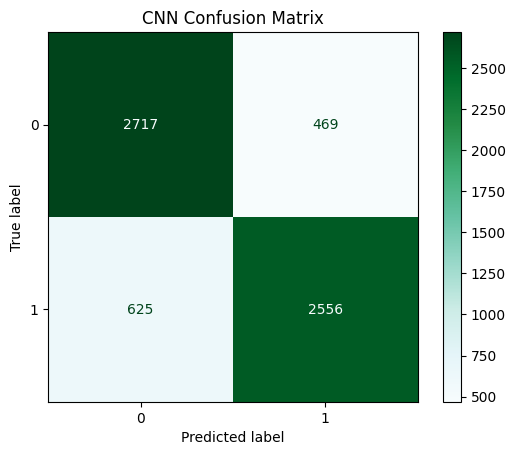

In [ ]:
if __name__ == '__main__':
  loss, accuracy = cnn_model.evaluate(X_test, y_test)
  print(f"CNN Accuracy: {accuracy}")

  predictions = cnn_model.predict(X_test)
  pred_labels = (predictions > 0.5).astype(int)

  cm = confusion_matrix(y_test, pred_labels)

  ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap='BuGn')
  plt.title("CNN Confusion Matrix")
  plt.show()

You can now run the cell below to save your CNN model. You will need to download this saved model to your local machine for submission.

In [ ]:
if __name__ == '__main__':
  cnn_model.save("cnn_model.keras")